In [59]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statistics
import seaborn as sns; sns.set(style="whitegrid")
import math
%run Cointegration.py
%matplotlib inline

In [78]:
def coefficients(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.params['temp'],
            "angular":model.params['x'],
            "intercept":model.params['const']}

def regression(y, x, period):
    y, x = get_values(y, x, period)
    pairs = pd.DataFrame()
    
    pairs['y'] = y
    pairs['x'] = x
    pairs['temp'] = timeline(period)
    
    X = pairs[['x', 'temp']]
    X = sm.add_constant(X)
    model = sm.OLS(pairs['y'], X).fit()
    return model

def resid(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    temp = timeline(period)
    res = y-coef['angular']*x-temp*coef['temp']-coef['intercept']
    #res[0]=0
    return res

def timeline(period):
    numbers = np.arange(1, period+1)
    temp = period - numbers + 1
    return temp

def lot(y_lot, coef):
    return [y_lot, int(y_lot*coef['angular'])]

def returns(y, x, period):
    y, x = get_values(y, x, period)
    y_log = np.log(y/y.shift(1))
    x_log = np.log(x/x.shift(1))
    return [y_log, x_log]
    
def get_values(y, x, period):
    if(period <= 0):
        return y, x
    
    y = y.iloc[:period]
    x = x.iloc[:period]
    return y, x

def corr(y, x, period):
    y_log, x_log = returns(y, x, period)
    return y_log.corr(x_log)

def getdata(data, period):
    data_max = data[:period]
    return data_max

def invert(y, x, period):
    y, x = get_values(y, x, period)
    coef_main = coefficients(y, x, period)
    coef_invert = coefficients(x, y, period)
    if (abs(coef_main['temp'])<=abs(coef_invert['temp'])):
        return False
    return True

def ratio_diff(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    res = resid(y, x, period)
    diff = res.shift(1)-res
    diff[0]=0
    return diff

def ratio_continuo(y, x, period):
    y, x = get_values(y, x, period)
    ratio = y-x
    return ratio
    
def intercept_coef(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    res = resid(y, x, period)
    diff = ratio_diff(y, x, period)

    target = pd.DataFrame(res, columns=["target"])
    target = sm.add_constant(target)
    model = sm.OLS(diff, target).fit()
    return model.params['target']

def intercept_inter(y, x, period):
    ratio_cont = ratio_continuo(y, x, period)
    ratio_cont[0]=0
    diff_r = ratio_diff(y, x, period)
    
    ratio_cont = sm.add_constant(ratio_cont)
    model = sm.OLS(diff_r, ratio_cont).fit()
    return model.params['const']

def ornstein_uhlenbeck(y, x, period):
    coef = intercept_coef(y, x, period)
    
    beta = -np.log(1+intercept_coef(y, x, period))
    alpha = -(coef/intercept_inter(y, x, period))
    
    std = resid(y, x, period).std()
    sigma=std*np.sqrt(np.log(1+coef)/(np.power((1+coef),2)-1))
    
    half = 2/beta
    return {
        "halffile": half,
        "beta": beta,
        "alpha": alpha,
        "sigma": sigma
    }

def halffile(y, x, period):
    return ornstein_uhlenbeck(y, x, period)['halffile']
    
def statisticspair(y, x, period):
    res = resid(y, x, period)
    std = res.std()
    return {
        "std": std,
        "std_up": 2*std,
        "std_down": -2*std,
        "mean": res.mean(),
        "min": np.min(res)-2*std,
        "max": np.max(res)+2*std
    }

def trade_stop(y, x, period):
    res = resid(y, x, period)
    
    # acima do quadro "ESTATÍSTICAS"
    std_down = res.mean()-3.1*res.std()
    std_up = res.mean()+3.1*res.std()
    
    est = coefficients(y, x, period)
    l_res = resid(y, x, period)[0]
    price = x[0]
    
    value1 = (price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))/price
    value2 = price/(price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))
    return max(value1, value2)

def trade_output(y, x, period):
    price = x[0]
    est = coefficients(y, x, period)
    value1 = (est['angular']*price+est['intercept']+est['temp']*period)/price
    value2 = 1/((est['angular']*price+est['intercept']+est['temp']*period)/price)
    return max(value1, value2)

def trade_input(y, x, period):
    price = x[0]
    res = resid(y, x, period)
    l_res = res[0]
    est = coefficients(y, x, period)
    std_up = 2*res.std()
    std_down = -2*res.std()

    value1 = (price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))/price
    value2 = price/(price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))
    return max(value1, value2)

def loss_percent(y, x, period):
    return -abs(trade_stop(y, x, period)/trade_input(y, x, period)-1)

def current_percent(y, x, period):
    ratio_current = y[0]/x[0]
    v = 1/ratio_current
    return abs(trade_output(y, x, period)/max(ratio_current,v)-1)

def return_percent(y, x, period):
    return abs(trade_output(y, x, period)/trade_input(y, x, period)-1)

def loss(y, x, lot, period):
    return y[0]*lot*loss_percent(y, x, period)

def gain(y, x, lot, period):
    return current_percent(y, x, period)*lot*y[0]
    
def sinal(value):
    if(value < 0):
        return -1
    return 1

def dickey_fuller(series):
    model = ts.adfuller(series, 1)
    p_value = model[1]
    statistic = model[0]

    # Dickey-Fuller
    is_stationary = False
    if (p_value < .05):
        is_stationary = True

    # Augmented Dickey Fuller (ADF)
    if (abs(statistic) > abs(model[4]['1%'])):
        perc_stat = 99
    elif (abs(statistic) > abs(model[4]['5%'])):
        perc_stat = 95
    elif (abs(statistic) > abs(model[4]['10%'])):
        perc_stat = 90
    else:
        perc_stat = 0
    return {
        "is_stationary": is_stationary,
        "p_value": p_value,
        "adf": perc_stat,
        "statistic": statistic
    }

In [61]:
data = pd.read_csv('datasets/data_cart.csv', index_col=0)
data = data[::-1]

In [62]:
#'CYRE3', 'LREN3
y_symbol = 'SBSP3'
x_symbol = 'BPAC11'
period = 250

In [63]:
y, x = get_values(data[y_symbol], data[x_symbol],period)

In [64]:
print('halffile: {}'.format(halffile(y, x, period)))
print('corr: {}'.format(corr(y, x, period)))
print('trade_stop: {}'.format(trade_stop(y, x, period)))
print('trade_output: {}'.format(trade_output(y, x, period)))
print('trade_input: {}'.format(trade_input(y, x, period)))
print('loss_percent: {}'.format(loss_percent(y, x, period)*100))
print('current_percent: {}'.format(current_percent(y, x, period)*100))
print('return_percent: {}'.format(return_percent(y, x, period)*100))
print('loss: {}'.format(loss(y, x, 1000, period)))
print('gain: {}'.format(gain(y, x, 1000, period)))
print('intercept_coef: {}'.format(intercept_coef(y, x, period)))
print('intercept_inter: {}'.format(intercept_inter(y, x, period)))
print('invert: {}'.format(invert(y, x, period)))

halffile: 16.086526745825715
corr: 0.6886175644136427
trade_stop: 1.4613860145751516
trade_output: 1.2656383651389442
trade_input: 1.3853569572057418
loss_percent: -5.488048186711381
current_percent: 7.736565255250882
return_percent: 8.641714429201652
loss: -3160.566950727084
gain: 4455.487930498984
intercept_coef: -0.11690954743344231
intercept_inter: -0.2307584695268411
invert: False


In [79]:
dickey_fuller(resid(y, x, period))

{'is_stationary': True,
 'p_value': 0.00020699749059899263,
 'adf': 99,
 'statistic': -4.487646576335595}

In [66]:
statisticspair(y, x, period)

{'std': 2.69703992353291,
 'std_up': 5.39407984706582,
 'std_down': -5.39407984706582,
 'mean': 1.0629719326971099e-14,
 'min': -11.76040348035321,
 'max': 13.112905827963116}

In [67]:
ornstein_uhlenbeck(y, x, period)

{'halffile': 16.086526745825715,
 'beta': 0.12432764583684786,
 'alpha': -0.5066316641515243,
 'sigma': 2.026798853694359}

In [68]:
coefficients(y, x, period)

{'temp': -0.0009360655827960723,
 'angular': 0.5174837914302521,
 'intercept': 21.771890806644357}

In [70]:
reg = regression(y, x, period)
reg

In [71]:
data = pd.read_csv('datasets/data_cart.csv', index_col=0)
data = data[::-1]
data
#data.drop(['30/06/2020'], inplace=True)

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BPAC11,BRAP4,...,SUZB3,TAEE11,TIMP3,TOTS3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
02/07/2020,14.17,20.76,56.20,33.16,19.43,21.21,27.53,12.81,79.00,35.96,...,36.82,28.41,14.55,24.13,18.64,7.35,55.49,48.05,15.39,53.57
01/07/2020,14.36,20.67,56.03,33.07,19.28,21.16,27.70,12.84,76.50,35.44,...,37.14,28.49,14.47,23.75,18.80,7.34,54.54,48.08,15.99,52.59
30/06/2020,14.14,20.11,55.09,32.15,18.96,20.70,27.27,13.15,76.50,36.51,...,36.79,28.10,14.20,23.15,18.38,7.27,55.92,48.03,15.31,50.61
29/06/2020,14.26,20.73,54.96,33.44,19.56,21.41,28.25,12.96,76.00,36.34,...,37.73,28.67,13.77,22.42,18.00,7.15,55.63,48.20,15.38,49.92
26/06/2020,13.95,20.00,53.45,31.82,19.08,20.69,27.85,12.79,72.67,36.43,...,37.88,28.07,14.03,22.26,17.64,7.10,55.62,48.54,14.29,50.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25/04/2019,18.31,33.25,34.77,49.10,31.00,36.07,28.53,8.16,39.90,31.83,...,43.34,26.11,11.77,43.27,21.25,8.70,50.33,46.70,4.02,19.05
24/04/2019,17.72,33.48,33.50,48.31,31.01,35.65,27.80,7.95,39.67,31.71,...,41.69,26.31,11.87,43.20,21.38,8.59,50.36,46.46,3.93,18.80
23/04/2019,17.67,34.17,32.84,49.31,31.00,35.89,27.62,7.99,39.45,32.65,...,41.01,26.15,12.06,42.79,22.55,8.91,51.92,47.00,3.93,19.25


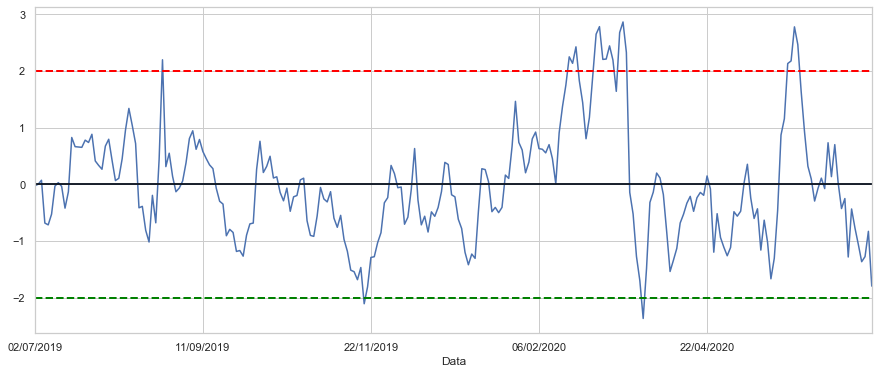

In [72]:
res = resid(data[y_symbol], data[x_symbol], period)
# antes de plotar os dados devem ser invertidos para ordem crescente
ret = zscore(res[::-1])
std = ret.std()
ret.plot(figsize=(15,6))
plt.axhline(ret.mean())

plt.axhline(0, color='black',label='mean') # Add the mean of residual
plt.axhline(2*std, color='red', linestyle='--', linewidth=2)
plt.axhline(-2*std, color='green', linestyle='--', linewidth=2)

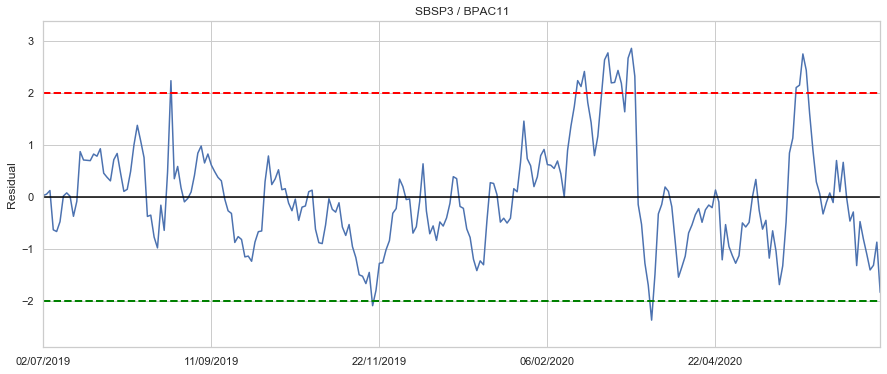

In [73]:
show(data[::-1], y_symbol, x_symbol, period)

In [74]:
"""zscore(model.resid)[::-1].plot(figsize=(15,6))"""

'zscore(model.resid)[::-1].plot(figsize=(15,6))'

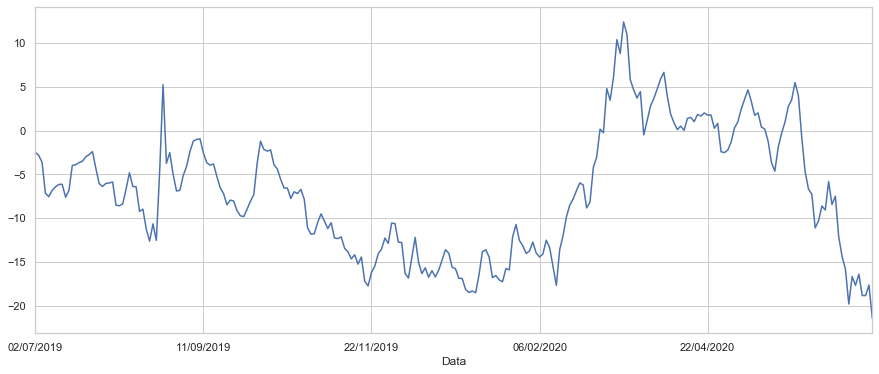

In [75]:
ratio_continuo(y, x, period)[::-1].plot(figsize=(15,6))